In [1]:
import numpy as np
import logging
import gzip
import matplotlib.pyplot as plt

PWD="/home/duzicman/projects/tau/statistical_machine_learning/logistic_classifier/datasets"
DATASET = {"labels": {"path" :PWD + "/train-labels-idx1-ubyte.gz", "offset":8}, "data": {"path": PWD + "/train-images-idx3-ubyte.gz", "offset":16}}
IMAGE_LENGTH = 28
IMAGE_SIZE = IMAGE_LENGTH ** 2
TRAINING_SET_SIZE = 0.6
VALIDATION_SET_SIZE = 0.2
TEST_SET_SIZE = 0.2
INITIAL_LEARNING_RATE = 0.0000002

In [2]:
def load_dataset(file_path, offset):
    with gzip.open(file_path, 'rb') as data_file:
        data = np.frombuffer(data_file.read(), np.uint8, offset=offset)
    return data

x_sample = load_dataset(DATASET["data"]["path"], DATASET["data"]["offset"])
t_labels = load_dataset(DATASET["labels"]["path"], DATASET["labels"]["offset"])


In [3]:
DATA_SIZE = 1000
def one_hot_encoding(labels):
    label_ammount = np.max(labels) + 1
    return np.eye(label_ammount)[labels]

def format_dataset(x_sample, labels):
    labels = one_hot_encoding(labels)
    x_sample = np.reshape(x_sample, (-1, IMAGE_SIZE))
    x_sample = np.c_[x_sample, np.ones(x_sample.shape[0])]
    return x_sample, labels

def split_data_set(x_sample, t_labels, training_size, validation_size, test_size):
    indices = np.random.permutation(x_sample.shape[1])
    print(x_sample.shape)
    training_idx, validation_idx, test_idx = indices[:int(len(indices) * training_size)], indices[int(len(indices) * training_size):int(len(indices) * (validation_size + training_size))], indices[int(len(indices) * (validation_size + training_size)):]
    training = [x_sample[training_idx, :], t_labels[training_idx, :]]
    test = [x_sample[test_idx, :], t_labels[test_idx, :]]
    validation = [x_sample[validation_idx, :], t_labels[validation_idx, :]]
    return training, test, validation


x_sample, t_labels = format_dataset(x_sample, t_labels)
training, test, validation = split_data_set(x_sample, t_labels, TRAINING_SET_SIZE, VALIDATION_SET_SIZE, TEST_SET_SIZE)


class_number = t_labels.shape[1]
training[0] = np.transpose(training[0])
test[0] = np.transpose(test[0])
validation[0] = np.transpose(validation[0])

(60000, 785)


In [4]:
def show_image(image):
    pixels = np.reshape(image, (IMAGE_LENGTH, IMAGE_LENGTH))
    plt.imshow(pixels, cmap='gray')
    plt.show()
# show_image(features[0])
#TODO I added extra normilization pixel so it doesnt work noe
# print(labels[0])


In [5]:
def cross_entropy_loss(y_labels_probabilites, t_labels) -> float:
    natural_log = lambda x: np.log(x)
    y_logged = np.matrix.transpose(np.vectorize(natural_log)(y_labels_probabilites))
    return -np.trace(np.matmul(t_labels, y_logged))

def caculate_lables_probabilities(w_weights, x_sample):
    # a_logits = np.matmul(np.transpose(x_sample), w_weights)
    a_logits = np.matmul(np.transpose(x_sample), w_weights)
    exponent = lambda x: np.exp(x)
    exponent_logits = np.vectorize(exponent)(a_logits)
    row_summation = np.sum(exponent_logits, axis=1)[:, np.newaxis]
    y_labels_probabilities = exponent_logits /  row_summation
    return y_labels_probabilities

def cross_entropy_loss_gradient(y_label_probabilites, t_labels, x_sample):
    return np.matmul(x_sample, (y_label_probabilites - t_labels))

def classification_accuracy(y_label_probabilites, t_labels):
    classification = np.eye(y_label_probabilites.shape[0], y_label_probabilites.shape[1])[np.argmax(y_label_probabilites, axis=1)]
    return np.sum(np.all(t_labels == classification, axis=1)) / classification.shape[0]

def callisification_matrics(w_weights, t_labels, x_sample):
    y_labels_probabilities = caculate_lables_probabilities(w_weights, x_sample)
    accuracy = classification_accuracy(y_labels_probabilities, t_labels)
    loss = cross_entropy_loss(y_labels_probabilities, t_labels)
    return y_labels_probabilities, accuracy, loss




#TODO rename probablity to a single name
#TODO start with random probabilities
eta_learning_rate = INITIAL_LEARNING_RATE

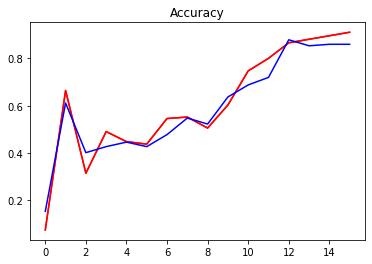

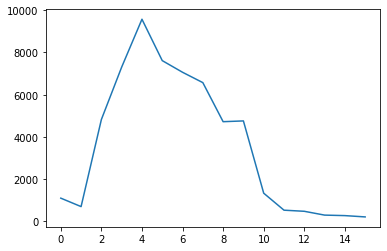

Training Loss 194.438395787031
Training Accuraccy 0.910828025477707
Validation Loss 171.60137591856972
Validation Accuraccy 0.8598726114649682
Steps 16
Test Accuraccy 0.7834394904458599


In [11]:
def gradient_descent(w_initial_weights, training, validation, eta_learning_rate, loss_epsilon):
    w_weights = w_initial_weights
    training_accuracies = []
    training_losses = []
    validation_losses = []
    validation_accuracies = []
    #TODO change stop conditiono to accuracies?
    x_training_sample, t_training_labels = training
    x_validation_sample, t_validation_labels = validation
    while len(validation_accuracies) < 2 or abs(validation_accuracies[-1] - validation_accuracies[-2]) > loss_epsilon:
        y_training_labels_probabilities, training_accuracy, training_loss = callisification_matrics(w_weights, t_training_labels, x_training_sample)
        y_validation_labels_probabilities, validation_accuracy, validation_loss = callisification_matrics(w_weights, t_validation_labels, x_validation_sample)
        loss_gradient = cross_entropy_loss_gradient(y_training_labels_probabilities, t_training_labels, x_training_sample)
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        w_weights -= loss_gradient * eta_learning_rate
    
    plt.title("Accuracy")
    plt.plot(range(len(training_accuracies)),training_accuracies, color="red")
    plt.plot(training_accuracies, color="red")
    plt.plot(validation_accuracies, color="blue")
    plt.show()
    plt.plot(training_losses)
    plt.show()
    print("Training Loss {}".format(training_loss))
    print("Training Accuraccy {}".format(training_accuracy))
    print("Validation Loss {}".format(validation_loss))
    print("Validation Accuraccy {}".format(validation_accuracy))
    print("Steps {}".format(len(training_losses)))
    return w_weights


w_weights = gradient_descent(np.zeros((IMAGE_SIZE + 1, class_number)), training, validation, eta_learning_rate, 0.001)
x_test_sample, t_test_labels = test

_, test_accuracy, _ = callisification_matrics(w_weights, t_test_labels, x_test_sample)
print("Test Accuraccy {}".format(test_accuracy))

